In [1]:
import pandas as pd

# 1) 정제된 데이터 다시 로드
df = pd.read_csv("total_clean.csv", parse_dates=["Date"])

# 2) 숫자 컬럼 타입 다시 한 번 확실히 맞추기
num_cols = ["CustomerID", "TotalCost", "Quantity", "EffectivePrice"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print(df.dtypes)
print(df.head())


CustomerID                 float64
Date                datetime64[ns]
MeterCategory               object
MeterSubCategory            object
MeterName                   object
ChargeType                  object
EffectivePrice             float64
MaskedSub                   object
Quantity                   float64
TotalCost                  float64
dtype: object
   CustomerID       Date     MeterCategory  \
0       100.0 2025-08-20  Virtual Machines   
1       100.0 2025-08-21  Virtual Machines   
2       100.0 2025-08-10  Virtual Machines   
3       100.0 2025-08-29  Virtual Machines   
4       100.0 2025-08-09  Virtual Machines   

                       MeterSubCategory MeterName ChargeType  EffectivePrice  \
0  Virtual Machines Dsv5 Series Windows    D8s v5      Usage          0.5502   
1  Virtual Machines Dsv5 Series Windows    D8s v5      Usage          0.5502   
2  Virtual Machines Dsv5 Series Windows    D8s v5      Usage          0.5502   
3  Virtual Machines Dsv5 Series Windows

In [2]:
cust_id = 100  # 다른 고객 보고 싶으면 숫자만 바꾸면 됨

# 1) 해당 고객 데이터만 필터링 + 날짜별 TotalCost 합계
ts = (
    df[df["CustomerID"] == cust_id]
    .groupby("Date")["TotalCost"]
    .sum()
    .sort_index()
)

print("고객 ID:", cust_id)
print("데이터 포인트 개수:", len(ts))
print(ts.head())
print("날짜 범위:", ts.index.min(), "~", ts.index.max())


고객 ID: 100
데이터 포인트 개수: 184
Date
2025-05-01    9.539247e+07
2025-05-02    9.018116e+07
2025-05-03    8.804921e+07
2025-05-04    8.799966e+07
2025-05-05    8.928921e+07
Name: TotalCost, dtype: float64
날짜 범위: 2025-05-01 00:00:00 ~ 2025-10-31 00:00:00


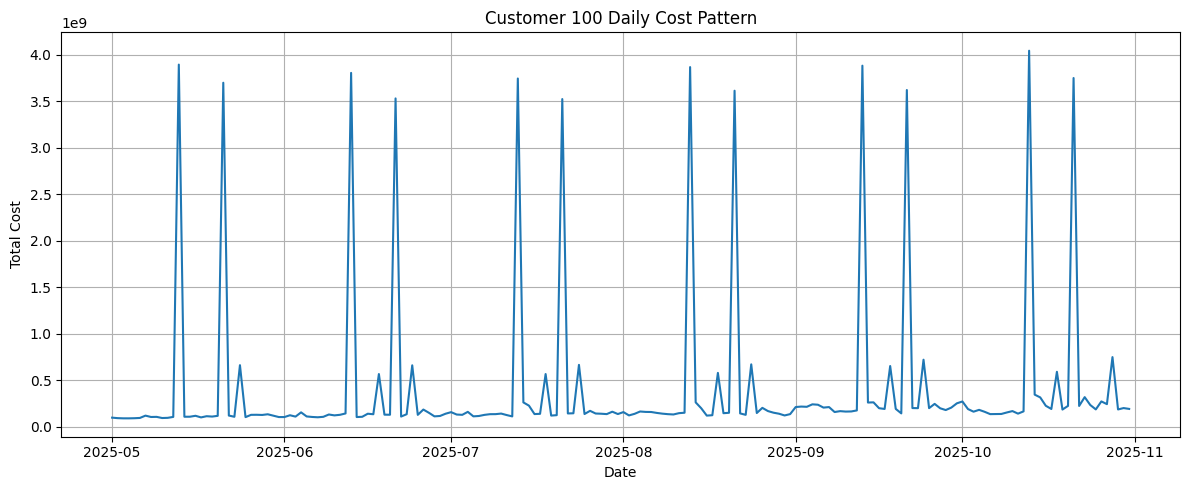

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(ts.index, ts.values)
plt.title(f"Customer {cust_id} Daily Cost Pattern")
plt.xlabel("Date")
plt.ylabel("Total Cost")
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
split_point = int(len(ts) * 0.8)

train = ts.iloc[:split_point]
test  = ts.iloc[split_point:]

print("Train size:", len(train))
print("Test size :", len(test))
print("Train 기간:", train.index.min(), "~", train.index.max())
print("Test 기간 :", test.index.min(), "~", test.index.max())


Train size: 147
Test size : 37
Train 기간: 2025-05-01 00:00:00 ~ 2025-09-24 00:00:00
Test 기간 : 2025-09-25 00:00:00 ~ 2025-10-31 00:00:00


In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()

train_values = train.values.reshape(-1, 1)
test_values  = test.values.reshape(-1, 1)

train_scaled = scaler.fit_transform(train_values)
test_scaled  = scaler.transform(test_values)

print("✅ 정규화 완료")
print("train shape:", train_scaled.shape)
print("test shape :", test_scaled.shape)
print("train min/max:", train_scaled.min(), train_scaled.max())
print("test min/max :", test_scaled.min(), test_scaled.max())


✅ 정규화 완료
train shape: (147, 1)
test shape : (37, 1)
train min/max: 0.0 0.9999999999999999
test min/max : 0.0119148244241375 1.0392734773005508


In [6]:
# 슬라이딩 윈도우 생성 함수
def create_sequences(data, window_size=30):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
    return np.array(X)

WINDOW_SIZE = 7

X_train = create_sequences(train_scaled, WINDOW_SIZE)
X_test  = create_sequences(test_scaled, WINDOW_SIZE)

print("✅ 시퀀스 생성 완료")
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)


✅ 시퀀스 생성 완료
X_train shape: (140, 7, 1)
X_test shape : (30, 7, 1)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

# 모델 구조 정의
model = Sequential([
    LSTM(32, activation="relu", input_shape=(WINDOW_SIZE, 1), return_sequences=False),
    RepeatVector(WINDOW_SIZE),
    LSTM(32, activation="relu", return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer="adam", loss="mse")

model.summary()


C:\dev\ds-playground\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 32)               │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 7, 1)                │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU 사용 가능 여부:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.20.0
GPU 사용 가능 여부: []


In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, X_train,          # 오토인코더라서 입력=정답
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    shuffle=False,
    callbacks=[early_stop]
)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 0.0570 - val_loss: 0.0915
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0536 - val_loss: 0.0855
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0517 - val_loss: 0.0817
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0512 - val_loss: 0.0803
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0509 - val_loss: 0.0802
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0505 - val_loss: 0.0800
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0500 - val_loss: 0.0794
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0495 - val_loss: 0.0784
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0490 - val_loss: 0.0776
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0484 - val_loss: 0.0769
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0479 - val_loss: 0.0762
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0472 - val_loss: 0.0751


In [10]:
# 학습 데이터 재구성
X_train_pred = model.predict(X_train)

# 재구성 오차 (MSE)
train_mse = np.mean(np.square(X_train_pred - X_train), axis=(1,2))

print("Train reconstruction error statistics")
print("min:", train_mse.min())
print("max:", train_mse.max())
print("mean:", train_mse.mean())
print("std:", train_mse.std())

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
Train reconstruction error statistics
min: 5.4808807479776594e-05
max: 0.04699707215871217
mean: 0.00900771668829642
std: 0.010578714697405171


In [11]:
# ✅ 이상치 기준선 설정
threshold = train_mse.mean() + 1.5 * train_mse.std()

print("📌 이상치 기준선(threshold):", threshold)


📌 이상치 기준선(threshold): 0.02487578873440418


In [12]:
# 1) 테스트 시퀀스 재구성
X_test_pred = model.predict(X_test)

# 2) 재구성 오차(MSE) 계산
test_mse = np.mean(np.square(X_test_pred - X_test), axis=(1, 2))

print("Test reconstruction error statistics")
print("min :", test_mse.min())
print("max :", test_mse.max())
print("mean:", test_mse.mean())
print("std :", test_mse.std())

# 3) 기준선을 넘는 시퀀스(이상 후보) 개수
anomaly_flags = test_mse > threshold
print("\n기준선(threshold)을 초과한 시퀀스 수:", anomaly_flags.sum(), "/", len(test_mse))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Test reconstruction error statistics
min : 3.139335973622749e-05
max : 0.09680883956532862
mean: 0.01709512314179233
std : 0.02312758483018355

기준선(threshold)을 초과한 시퀀스 수: 9 / 30


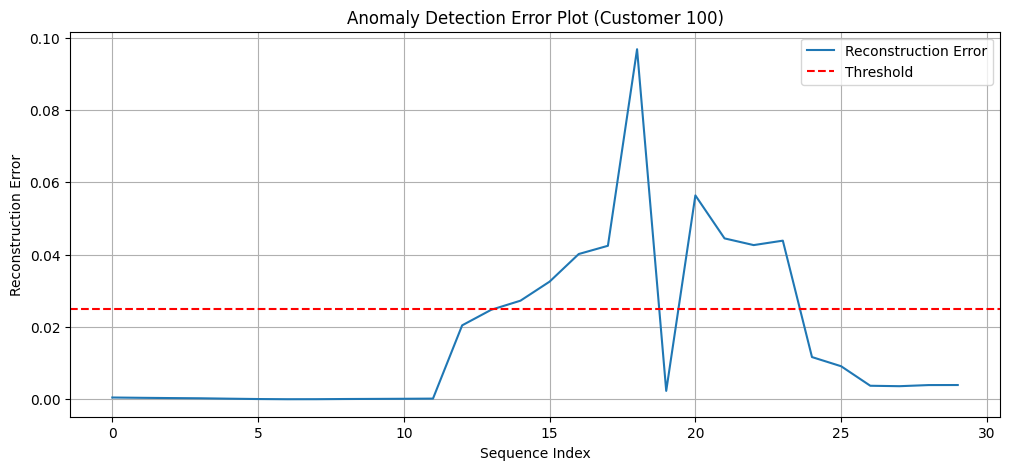

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test_mse, label="Reconstruction Error")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")

plt.title(f"Anomaly Detection Error Plot (Customer {cust_id})")
plt.xlabel("Sequence Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.show()


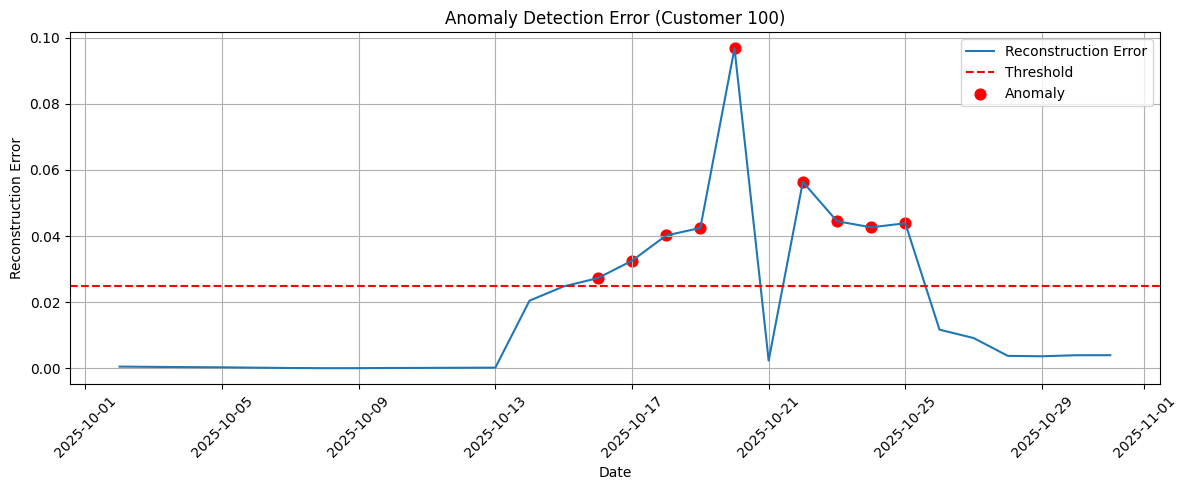

In [14]:
# 시퀀스에 대응되는 날짜 생성 (윈도우 마지막 날짜)
test_dates = ts.index[WINDOW_SIZE + split_point : WINDOW_SIZE + split_point + len(test_mse)]

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test_dates, test_mse, label="Reconstruction Error")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")

# 이상치 위치 표시
anomaly_dates = test_dates[anomaly_flags]
anomaly_values = test_mse[anomaly_flags]
plt.scatter(anomaly_dates, anomaly_values, color="red", s=60, label="Anomaly")

plt.title(f"Anomaly Detection Error (Customer {cust_id})")
plt.xlabel("Date")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
# 이상치 발생 날짜 리스트
anomaly_dates = test_dates[anomaly_flags]
print("이상 발생 날짜:")
print(anomaly_dates)


이상 발생 날짜:
DatetimeIndex(['2025-10-16', '2025-10-17', '2025-10-18', '2025-10-19',
               '2025-10-20', '2025-10-22', '2025-10-23', '2025-10-24',
               '2025-10-25'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [19]:
# 이상 날짜의 원본 데이터 필터링
abnormal_raw = df[
    (df["CustomerID"] == cust_id) &
    (df["Date"].isin(anomaly_dates))
]

# Subscription별 비용 집계
subscription_summary = abnormal_raw.groupby("MaskedSub")["TotalCost"].sum().sort_values(ascending=False)

print("📌 이상치 기간 Subscription별 비용:")
print(subscription_summary)


📌 이상치 기간 Subscription별 비용:
MaskedSub
sub_4d80647733e6dde7    8.807883e+08
sub_7db9f657c5f32b75    5.354645e+08
sub_15eb99bfdefef638    6.149141e+07
sub_d5b57b1ea9d49ef0    5.427588e+07
sub_fc7175a5166dfa30    4.365950e+07
                            ...     
sub_e00b0a432264a63c    1.536453e+01
sub_4ac64088c3c1f728    3.537340e+00
sub_807fec88a44f1455    3.492039e-01
sub_ce4bf6c194ffa9a6    0.000000e+00
sub_8e1fb50676863fa8    0.000000e+00
Name: TotalCost, Length: 674, dtype: float64


In [21]:
target_sub = "sub_4d80647733e6dde7"

sub_ts = (
    df[(df["CustomerID"] == cust_id) & (df["MaskedSub"] == target_sub)]
      .groupby("Date")["TotalCost"]
      .sum()
      .sort_index()
)

print(sub_ts.describe())


count    1.840000e+02
mean     1.271915e+08
std      4.121374e+08
min      2.722717e+07
25%      3.651326e+07
50%      4.215651e+07
75%      5.624089e+07
max      2.454825e+09
Name: TotalCost, dtype: float64


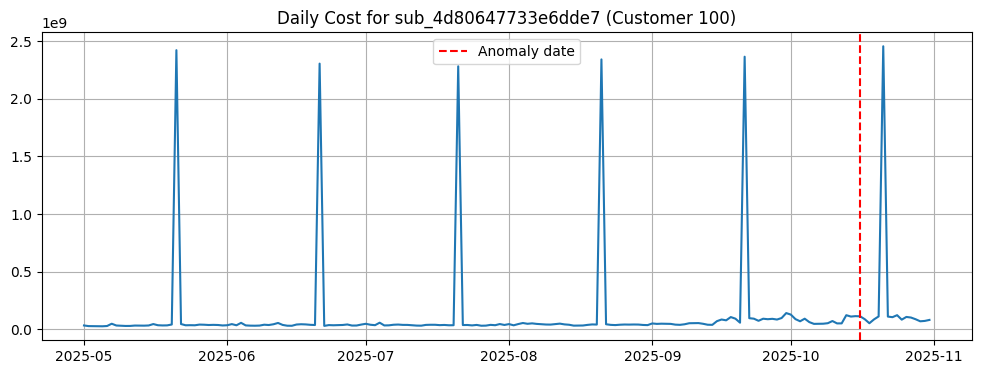

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(sub_ts.index, sub_ts.values)
plt.axvline(anomaly_dates.min(), color="red", linestyle="--", label="Anomaly date")
plt.title(f"Daily Cost for {target_sub} (Customer {cust_id})")
plt.legend()
plt.grid(True)
plt.show()


In [23]:
#  이상 날짜의 원본 데이터 (이미 만들어둔 abnormal_raw 재사용)
# abnormal_raw = df[
#     (df["CustomerID"] == cust_id) &
#     (df["Date"].isin(anomaly_dates))
# ]

# 구독 + MeterCategory + MeterSubCategory별 비용 집계
group_cols = ["MaskedSub", "MeterCategory", "MeterSubCategory"]

anomaly_detail = (
    abnormal_raw
    .groupby(group_cols)["TotalCost"]
    .sum()
    .reset_index()
    .sort_values("TotalCost", ascending=False)
)

print(" 이상 기간 구독 + 카테고리별 비용 상위 20개")
print(anomaly_detail.head(20))


 이상 기간 구독 + 카테고리별 비용 상위 20개
                  MaskedSub       MeterCategory  \
6624   sub_7db9f657c5f32b75  Cognitive Services   
3562   sub_4d80647733e6dde7    Azure Databricks   
3596   sub_4d80647733e6dde7             Storage   
6623   sub_7db9f657c5f32b75  Cognitive Services   
3614   sub_4d80647733e6dde7    Virtual Machines   
3625   sub_4d80647733e6dde7    Virtual Machines   
11498  sub_d5b57b1ea9d49ef0      Azure Firewall   
3626   sub_4d80647733e6dde7    Virtual Machines   
13641  sub_fc7175a5166dfa30    Virtual Machines   
3635   sub_4d80647733e6dde7     Virtual Network   
383    sub_15eb99bfdefef638             Storage   
2281   sub_36fabe3ea617baac            Sentinel   
3607   sub_4d80647733e6dde7             Storage   
3619   sub_4d80647733e6dde7    Virtual Machines   
3578   sub_4d80647733e6dde7       Log Analytics   
3624   sub_4d80647733e6dde7    Virtual Machines   
5430   sub_6d1436a3e751f42d    Virtual Machines   
12152  sub_e26049982ae95fd7    Virtual Machines   
363

In [24]:
target_sub = "sub_98f37001440b9a81"  # 확인하고 싶은 MaskedSub ID

sub_detail = (
    abnormal_raw[abnormal_raw["MaskedSub"] == target_sub]
    .groupby(["MeterCategory", "MeterSubCategory"])["TotalCost"]
    .sum()
    .reset_index()
    .sort_values("TotalCost", ascending=False)
)

print(f" {target_sub} 구독의 이상 기간 카테고리별 비용")
print(sub_detail.head(20))


 sub_98f37001440b9a81 구독의 이상 기간 카테고리별 비용
Empty DataFrame
Columns: [MeterCategory, MeterSubCategory, TotalCost]
Index: []


In [25]:
total_anomaly_cost = anomaly_detail["TotalCost"].sum()

anomaly_detail["Ratio(%)"] = anomaly_detail["TotalCost"] / total_anomaly_cost * 100

print(" 이상 기간 구독+카테고리별 비용 비중 상위 20개")
print(anomaly_detail.head(20))


 이상 기간 구독+카테고리별 비용 비중 상위 20개
                  MaskedSub       MeterCategory  \
6624   sub_7db9f657c5f32b75  Cognitive Services   
3562   sub_4d80647733e6dde7    Azure Databricks   
3596   sub_4d80647733e6dde7             Storage   
6623   sub_7db9f657c5f32b75  Cognitive Services   
3614   sub_4d80647733e6dde7    Virtual Machines   
3625   sub_4d80647733e6dde7    Virtual Machines   
11498  sub_d5b57b1ea9d49ef0      Azure Firewall   
3626   sub_4d80647733e6dde7    Virtual Machines   
13641  sub_fc7175a5166dfa30    Virtual Machines   
3635   sub_4d80647733e6dde7     Virtual Network   
383    sub_15eb99bfdefef638             Storage   
2281   sub_36fabe3ea617baac            Sentinel   
3607   sub_4d80647733e6dde7             Storage   
3619   sub_4d80647733e6dde7    Virtual Machines   
3578   sub_4d80647733e6dde7       Log Analytics   
3624   sub_4d80647733e6dde7    Virtual Machines   
5430   sub_6d1436a3e751f42d    Virtual Machines   
12152  sub_e26049982ae95fd7    Virtual Machines   
36